# recommendation system using Word2Vec
DY industry project (Y-Data 2019)

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import timeit

import warnings
warnings.filterwarnings('ignore')

# input files
 + mapping of terms to actual coloumn names
 + df_full has all coloumns, just for info
 + df_raw has data from the following query:
+
SELECT sku, dyid, timestamp, groupid 
FROM "ds_event"."ds_events_sephora_au"
WHERE sku IS NOT NULL
ORDER BY timestamp DESC
limit 10000000;
+ timespan covered in raw_df:
+ earliest timestamp = 2019-08-07 06:43:33.779
+ most recent timestamp = 2020-02-18 22:59:48.758

In [2]:
df_raw = pd.read_csv('test_events_new.csv')
# df_full = pd.read_csv('test_events_big.csv')
feed_df = pd.read_csv('section_feed.csv')
itemID = 'sku'
userID = 'dyid'
description = 'name'
timestamp = 'timestamp'

In [3]:
feed_df.isnull().sum()

sku           1145
name          1323
url           1331
price         3596
in_stock      3596
image_url     1393
categories    1392
dtype: int64

In [4]:
feed_df.dropna(subset = ['sku'], inplace=True)


In [5]:
#df_raw.groupby(itemID).sku.value_counts().mean()

In [6]:
# Mock data (in case we need it fo presentations)
# df = pd.read_excel('Online Retail.xlsx')
# itemID = 'StockCode'
# userID = 'CustomerID'
# description = 'Description'
# timestamp = 'InvoiceDate'

# basic EDA of raw_df
+ null values
+ duplictes

In [7]:
print(df_raw.shape, '\n', df_raw.dtypes)
df_raw.tail()

(10000000, 4) 
 sku          object
dyid          int64
timestamp     int64
groupid       int64
dtype: object


,sku,dyid,timestamp,groupid
9999995,27890,4517110749940314857,1565160220902,12817
9999996,207316,-4035224843652009239,1565160218103,19439
9999997,202144,-5323254590529555453,1565160217601,12179
9999998,207316,-4035224843652009239,1565160215769,19439
9999999,203175,6642809756860333372,1565160213779,18598


In [8]:
# check for missing values
df_raw.isnull().sum()

sku          0
dyid         0
timestamp    0
groupid      0
dtype: int64

In [9]:
# remove missing values
df_raw.dropna(inplace=True)

In [10]:
# remove rows where 'sku' is null
# df_raw.dropna(subset = [itemID], inplace=True)
print(df_raw.shape)

(10000000, 4)


In [11]:
# check for duplicates
#df_raw.duplicated().sum()
print(f'duplicated rows:{df_raw.duplicated().sum()}')

duplicated rows:965


# Q: 
can we remove those duplicates? they may nit be duplicates in original file

In [12]:
df_raw.drop_duplicates(subset = [userID, itemID], inplace=True, keep='last')
df_raw.shape

(7455212, 4)

# pre processing

In [13]:
print(df_raw.dtypes)
df_raw.sample(5)

sku          object
dyid          int64
timestamp     int64
groupid       int64
dtype: object


,sku,dyid,timestamp,groupid
1823155,215043,-828662166661977062,1578887081907,14096
9304304,191116,2603080946963936078,1566537385814,13556
9045531,208235,-2760706097564641294,1567070328993,19469
6276296,13203,-225179554598989879,1572333801072,14416
6614054,213448,-3778519660599153183,1571834165423,21541


# Q: 
- do we always want to work with strings? can we assume sku is always string/numeric?

In [14]:
# convert item id to string
df_raw[itemID]= df_raw[itemID].astype(str)

In [15]:
df_raw.dtypes

sku          object
dyid          int64
timestamp     int64
groupid       int64
dtype: object

In [16]:
# convert timestamp to pandas datetime
df_raw[timestamp] = pd.to_datetime(df_raw[timestamp], unit = 'ms')

# df = df.set_index(df[timestamp])
# df = df.sort_index()

df_raw.sort_values(timestamp, inplace=True, ascending=True) #may be redundent

In [17]:
df_raw.head(), df_raw.tail()

(            sku                 dyid               timestamp  groupid
 9999999  203175  6642809756860333372 2019-08-07 06:43:33.779    18598
 9999998  207316 -4035224843652009239 2019-08-07 06:43:35.769    19439
 9999997  202144 -5323254590529555453 2019-08-07 06:43:37.601    12179
 9999995   27890  4517110749940314857 2019-08-07 06:43:40.902    12817
 9999994  210282  8061443759760110214 2019-08-07 06:43:45.899        0,
       sku                 dyid               timestamp  groupid
 4  212261 -2499497366418245782 2020-02-18 22:59:48.758        0
 3  206796  -869194421557761063 2020-02-18 22:59:49.995    21922
 2  211189 -3130001434504735196 2020-02-18 22:59:52.081    20607
 1  216959 -5156621374223733360 2020-02-18 22:59:52.589    23162
 0  217042 -2170734847011820536 2020-02-18 22:59:53.162    23194)

In [18]:
feed_df

,sku,name,url,price,in_stock,image_url,categories
0,sku,name,url,NaN,NaN,image_url,categories
1,182491,Magic Black Powder Eye & Cheek Patch,https://www.sephora.com.au/products/caolion-ma...,9.0,True,https://static-reg.lximg.com/images/product_im...,skincare|masks-and-treatments|eye-care|caolion
3,"""",9,false,NaN,NaN,caolion-magic-black-powder-eye-and-cheek-patch,3.5
4,20370,Volume Conditioner,https://www.sephora.com.au/products/ouai-volum...,43.0,True,https://static-reg.lximg.com/images/product_im...,hair|shampoo-and-conditioner|conditioner|ouai
5,201864,Temporary Colour Gel,https://www.sephora.com.au/products/christophe...,51.0,True,https://static-reg.lximg.com/images/product_im...,hair|styling|hair-colour|christophe-robin
...,...,...,...,...,...,...,...
14504,192790,Behind The Scenes™ Balancing Bio-Cellulose Sec...,https://www.sephora.com.au/products/starskin-b...,18.0,False,https://static-reg.lximg.com/images/product_im...,skincare|masks-and-treatments|mask|star-skin
14505,192793,Eye Catcher™ Smoothing Bio-Cellulose Second Sk...,https://www.sephora.com.au/products/starskin-e...,18.0,True,https://static-reg.lximg.com/images/product_im...,skincare|masks-and-treatments|eye-care|star-skin
14506,10464,Blush Brush #2,https://www.sephora.com.au/products/antonym-bl...,33.0,True,https://static-reg.lximg.com/images/product_im...,tools-and-brushes|brushes|face-brushes|antonym
14507,29431,Brush Palette,https://www.sephora.com.au/products/artis-brus...,86.0,True,https://static-reg.lximg.com/images/product_im...,tools-and-brushes|bags-and-organisers|palette-...


In [19]:
# seperate raw data according to dates
split_date = pd.datetime(2019,11,1)

# df_older = df_raw.loc[df_raw[timestamp] < split_date]
df_newest = df_raw.loc[df_raw[timestamp] >= split_date]

df_newest.shape

(4354651, 4)

In [20]:
df = df_newest.copy()

In [21]:
#df.to_csv('section1.csv')

In [22]:
# check how many users we have
users = df[userID].unique().tolist()
print(f'# of user in data since {split_date} = {len(users)}')
df.tail()

# of user in data since 2019-11-01 00:00:00 = 1173521


,sku,dyid,timestamp,groupid
4,212261,-2499497366418245782,2020-02-18 22:59:48.758,0
3,206796,-869194421557761063,2020-02-18 22:59:49.995,21922
2,211189,-3130001434504735196,2020-02-18 22:59:52.081,20607
1,216959,-5156621374223733360,2020-02-18 22:59:52.589,23162
0,217042,-2170734847011820536,2020-02-18 22:59:53.162,23194


# split data to train and val
- assumption: to uild the model - we use entire data
- do I need this if we'll do CV?
- for CV do we split on users?
- split on dates vs latest session


In [23]:
# # shuffle customer ID's
# random.shuffle(users)

# # extract 90% of user ID's
# users_train = [users[i] for i in range(round(0.9*len(users)))]

# # split data into train and validation set
# train_df = df[df[userID].isin(users_train)]
# validation_df = df[~df[userID].isin(users_train)]

# split data into train and test set

train_test_split_date = pd.datetime(2020,2,1)
train_df = df.loc[df[timestamp] < train_test_split_date]
test_df = df.loc[df[timestamp] >= train_test_split_date]


In [24]:
train_df.shape, test_df.shape

((3646421, 4), (708230, 4))

In [25]:
train_seq_df = train_df.groupby(userID)[itemID].apply(list)
# train_seq_df.rename(columns={'sku': 'sku_train'})
train_seq_df.sample(10)

dyid
 4629700921023119654                    [202769, 12707, 12708]
-4895412643052699422    [202818, 26003, 181992, 194702, 33606]
 1265512055210373580                                  [215043]
-6913025117198645914                                  [216239]
 810648312459988777                                    [31313]
-8858580319468246265                                  [200109]
 1179943400299089197                            [33589, 21586]
-6435643475095227442                                   [24686]
 3066951519618042077                                   [34108]
 562950221286911730                            [26782, 213367]
Name: sku, dtype: object

In [26]:
train_sequences = train_seq_df.values
train_sequences

array([list(['31527', '13268', '212187', '217129', '28244', '26748', '211746', '211751', '15821', '31527', '194054', '26749', '214546', '214548', '19674', '206371', '209035', '210217', '206770', '32671', '192803', '192800', '192799', '190239', '212674', '211686', '214548', '210701', '214045', '215046', '215048', '26812', '210703', '210702', '25835']),
       list(['208960', '205570']), list(['207641', '192421']), ...,
       list(['949', '181776', '206796', '208871']),
       list(['12275', '215875', '216237', '214697', '194311', '26135', '207334', '26103', '206391']),
       list(['33986'])], dtype=object)

In [27]:
test_seq_df = test_df.groupby(userID)[itemID].apply(list)
test_seq_df.sample(10)

dyid
-2796734976189546200                                [213438]
 8764005237193370922                         [213383, 28165]
-5143110592487338767                                 [26219]
-7881299187403809490                                [210702]
-3377699517082907311                                 [32023]
-1693352899972997703    [215048, 33593, 28915, 26082, 33592]
-7295831214369601805                         [31862, 193671]
-8858580207758758699                                [214055]
-1094374364296948314                                [203122]
-540431713185128811                                 [200109]
Name: sku, dtype: object

In [28]:
test_sequences = test_seq_df.values
test_sequences

array([list(['214624', '15821']), list(['218652']), list(['213439']), ...,
       list(['28915']),
       list(['27972', '27971', '202727', '214515', '31811']),
       list(['31625'])], dtype=object)

from gensim documentation:
The full power of Gensim comes from the fact that a corpus doesn’t have to be a list, or a NumPy array, or a Pandas dataframe, or whatever. Gensim accepts any object that, when iterated over, successively yields documents.


# if we need to use pickle to store data

In [29]:
# import pickle

# with open('train_seq', 'wb') as fp:
#     pickle.dump(train_sequences, fp)
    
# with open('train_seq', 'rb') as fp:
#     train_sequences = pickle.load(fp)


# with open('test_seq', 'wb') as fp:
#     pickle.dump(test_sequences, fp)
    
# with open('test_seq', 'rb') as fp:
#     test_sequences = pickle.load(fp)
# len(test_sequences)


# generate word2vec embeddings for items

In [30]:
#Hyper Paramters
# Init signature:
# Word2Vec(
#     sentences=None,
#     corpus_file=None,
#     size=SIZE,
#     alpha=0.025,
#     window=WINDOW,
#     min_count=MINCOUNT,
#     max_vocab_size=None,
#     sample=0.001,
#     seed=1,
#     workers=3,
#     min_alpha=0.0001,
#     sg=0,
#     hs=0,
#     negative=5,
#     ns_exponent=0.75,
#     cbow_mean=1,
#     hashfxn=<built-in function hash>,
#     iter=5,
#     null_word=0,
#     trim_rule=None,
#     sorted_vocab=1,
#     batch_words=10000,
#     compute_loss=False,
#     callbacks=(),
#     max_final_vocab=None,
# )


# Q:
- version control (Git)
- data, code, hyperprams, seed etc.

In [63]:
# test area - a single model generation

WINDOW = 5
SIZE = 75
MIN_COUNT = 3
NEGATIVE = 5
verbose_dict = {}

model = Word2Vec(window = WINDOW, size= SIZE, sg = 1, min_count = MIN_COUNT,
                 hs = 0, negative = NEGATIVE, # for negative sampling
                 alpha=0.01, min_alpha=0.0007,
                 seed = 42, workers = 4)

verbose_dict.update({'window': WINDOW, 'size': SIZE, 'min_count': MIN_COUNT,'negative': NEGATIVE})  


In [64]:
verbose_dict

{'window': 5, 'size': 75, 'min_count': 3, 'negative': 5}

In [ ]:
model.build_vocab(train_sequences, progress_per=1000)

model.train(train_sequences, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

In [ ]:
# save word2vec model
model.save('word2vec_17032020_01.model')

In [ ]:
# for efficiency
model.init_sims(replace=True)

In [ ]:
print(model)

In [ ]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

# add descriptions from feed table

In [31]:
# sku_name = pd.merge(df, feed_df, how='inner', on=['sku', 'sku'])
item_catalog = pd.merge(df_raw, feed_df, how='inner', on=['sku', 'sku'])


In [32]:
# RINA: is it necassey to buid this dict? we have df with this data

items = item_catalog[[itemID, description]]
# remove duplicates
items.drop_duplicates(inplace=True, subset=itemID, keep='last')

# create product-ID and product-description dictionary
items_dict = items.groupby(itemID)[description].apply(list).to_dict()

print(items)

            sku                                       name
626      203175                 Prime + Set Complexion Kit
11848    207316         Sun Stalk'r Instant Warmth Bronzer
19044    202144  Stunna Lip Paint Longwear Fluid Lip Color
19151     33723                          Two Tone Lipstick
29195     29581                            Cream Lip Stain
...         ...                                        ...
6586571  216851                  Agave+ Intensive Lip Mask
6586573  216844         Power Move Creamy Matte Lip Crayon
6586575  216839         Power Move Creamy Matte Lip Crayon
6586576  216837         Power Move Creamy Matte Lip Crayon
6586577  212261         Changemaker Skin-Optimizing Primer

[10715 rows x 2 columns]


In [33]:
items.set_index('sku')

,name
sku,
203175,Prime + Set Complexion Kit
207316,Sun Stalk'r Instant Warmth Bronzer
202144,Stunna Lip Paint Longwear Fluid Lip Color
33723,Two Tone Lipstick
29581,Cream Lip Stain
...,...
216851,Agave+ Intensive Lip Mask
216844,Power Move Creamy Matte Lip Crayon
216839,Power Move Creamy Matte Lip Crayon


In [43]:
def similar_items(model, v, n = 5):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:] # all but the product itself
#     print(ms)
    # extract name and similarity score of the similar products
    desc_ms = []
    for j in ms:
        pair = (items_dict[j[0]][0], j[1])
#         print(pair) # added just till we fix catalog isues
        desc_ms.append(pair)
        
    return ms, desc_ms        

# Displaying similarities and recomendations

In [44]:
from imageio import imread

topN = 10

def display_image_by_item(ID):
    url = feed_df[feed_df.sku == str(ID)].iloc[0, 5]
    plt.axis('off')

    image = imread(url)
    plt.imshow(image)

def get_image_by_item(ID):
    url = feed_df[feed_df.sku == str(ID)].iloc[0, 5]
    return imread(url)
    
def display_impages(image_list):
    plt.figure(figsize=(20,10))
    columns = 5
    plt.axis('off')

    for i, image in enumerate(image_list):
        plt.subplot(len(image_list) / columns + 1, columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

def get_last_items_by_user(user, lastN = 3):
    pass

def get_similar_by_item(sample_code, topN = 5):
    ms, _ = similar_items(model, model[str(sample_code)], n=topN)
    predictions = [item[0] for item in ms]
    debug_items = []
    for item_code in predictions:
            try:
                # test the dictionary
#                 print(items_dict[str(item_code)])
                url = feed_df[feed_df.sku == str(item_code)].iloc[0, 5]
                from imageio import imread
                image = imread(url)
                plt.axis('off')
                plt.imshow(image)    
            except KeyError:
                debug_items.append(item_code)
            pass


In [97]:
items.sample(13)

,sku,name
6334664,193552,Bird's Nest Blurring Beauty Mousse
4001373,416,F82 Round Kabuki™ Brush
1472230,198877,Unicorn Essence
6586522,216145,Ultra HD Light Capturing Self-Setting Concealer
5124615,27185,Blush Trio
1342557,206306,Superberry Hydrate + Glow Dream Mask
3326634,14768,Maintain The Mane Conditioner
3081403,194356,"""Mini Precisely"
2016632,210280,Eye Primer
4936010,193960,Rouge G de Guerlain Customizable Matte Lipstic...


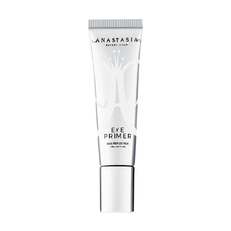

In [111]:
sample_code = 210280
display_image_by_item(sample_code)

In [112]:
ms, _ = similar_items(cur_model, cur_model[str(sample_code)], n=5)
# debug_items 
predictions = [item[0] for item in ms]

In [113]:
images = []
for ID in predictions:
    image = get_image_by_item(ID)
    images.append(image)

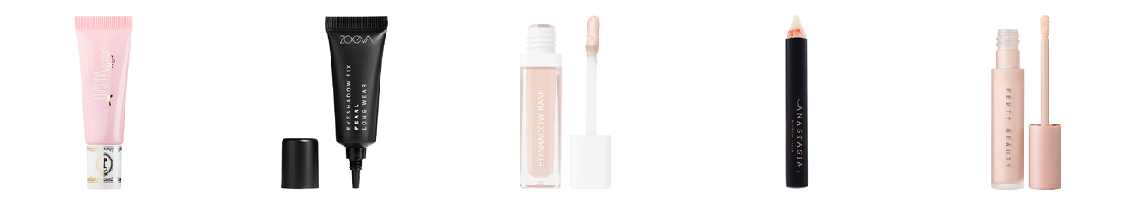

In [114]:
# display similar items
display_impages(images)

In [50]:
train_seq_df.sample(10)

dyid
-8029917708825946931                                              [34965]
-3003900610594717718                               [25967, 209190, 26162]
 8579357716915902281                                              [17680]
-7638104708744839125                                             [199003]
-8615385819296972759     [212646, 212645, 211661, 211660, 213988, 213987]
-2526519217579913366    [205482, 32791, 212691, 35367, 209286, 208793,...
 3877599813316089658                                              [28901]
-8435241542150642048                              [213438, 35163, 193930]
 3440750662340315332    [200388, 210591, 10823, 211660, 215048, 215047...
 5908723258144423405                              [16680, 202730, 202729]
Name: sku, dtype: object

In [51]:
def aggregate_vectors(model, items):
    item_vec = []
    for i in items:
        try:
            item_vec.append(model[i])
        except KeyError:
            pass
        
    return np.mean(item_vec, axis=0)


In [52]:
# what do we do with users whם have 1 item in their history? we just get similarity

To calculate hit ratio for a single user:

Find all items in his/her history.
Spare the last item from this list.
Use all other items to feed the recommender and ask for n recommendations (This is where the HR@n comes from)
If the last (hidden) item appear in the n recommendations, it is a hit. If not, it's not a hit.

The whole Hit Rate of the system is the count of hits, divided by the test user count.

Apparently when n increases, the hit rate will generally increase.
(After a data-and-algorithm specific n value, the hit rate will no longer increase)

Some algorithms may perform better with small n's, while other might perform better with large n's.

So, it is common sense to use the real number of recommendations that will be used when the product goes live.

It doesn't make sense to optimize the system for 50 recommendations, if you will generate 5 recommendations in the final product.


# Evaluate - 2 problems to solve:
- some specific rows cause an error: 
---> 22     ms = model.similar_by_vector(user_vec, topn= 5)

TypeError: cannot unpack non-iterable numpy.float64 object

- when I populted the 'hit' column with a numer or a boolean I was not able to see the next items and predictions... working with a 'T', 'F' char worked. have no idea why 

In [53]:
# hyperparameters and performance

def cartesian_product(d):
    index = pd.MultiIndex.from_product(d.values(), names=d.keys())
    return pd.DataFrame(index=index).reset_index()

# hyperparam_dict = {'WINDOW': [3,5, 10], 
#                    'SIZE': [50, 75, 100, 150],
#                    'MIN_COUNT': [3, 4, 5],
#                    'NEGATIVE': [5, 10],
#                    'TOP_N_for_predict': [5, 10, 20]}

hyperparam_dict = {'WINDOW': [5, 10], 
                   'SIZE': [20, 32],
                   'MIN_COUNT': [3, 4, 5],
                   'NEGATIVE': [5, 7, 10]}
#                    'TOP_N_for_predict': [5, 10, 20]}

evaluation_df = cartesian_product(hyperparam_dict)
evaluation_df['hit_rate'] = 0
evaluation_df

,WINDOW,SIZE,MIN_COUNT,NEGATIVE,hit_rate
0,5,20,3,5,0
1,5,20,3,7,0
2,5,20,3,10,0
3,5,20,4,5,0
4,5,20,4,7,0
5,5,20,4,10,0
6,5,20,5,5,0
7,5,20,5,7,0
8,5,20,5,10,0
9,5,32,3,5,0


In [54]:
hit_rate_df = pd.concat([train_seq_df, test_seq_df], axis=1,
                        join='inner').copy()

hit_rate_df.columns = ['train_seq', 'test_seq']
hit_rate_df['hit'] = 'F'
hit_rate_df['next_item'] = ''
hit_rate_df['predictions'] = ''


In [55]:
def evaluate(model):   
    hit_rate_df['hit'] = 'F'
    hit_rate_df['next_item'] = ''
    hit_rate_df['predictions'] = ''
    # user_history_size and N are hyperparamteres
    user_history_size = 10 # past interactions we average to represent a user in our vector spece
    N = 20 # size of prediction in hitrate@N
    debug_users = []
    for index, row in hit_rate_df.iterrows():
        next_item =  row['test_seq'][0]
        row['next_item'] =  next_item
        agg_size = min(len(row['train_seq']), user_history_size)
        user_vec =  aggregate_vectors(model, row['train_seq'][-agg_size:])
        try:
            ms = model.similar_by_vector(user_vec, topn= N)
        except TypeError:
            debug_users.append(index)
            pass

    #     ms = model.similar_by_vector(user_vec, topn= N)
        predictions = [item[0] for item in ms]
        row['predictions'] = predictions
        if next_item in predictions:
            row.hit = 'T'
            
    num_F_hits = hit_rate_df[hit_rate_df.hit == 'F'].shape[0]
    num_T_hits = hit_rate_df[hit_rate_df.hit == 'T'].shape[0]
    hit_rate = num_T_hits/(num_T_hits + num_F_hits)
    print(f'# of True hits {num_T_hits}, out of {num_T_hits + num_F_hits}, hit rate is {hit_rate:.4f}')
    return hit_rate


In [56]:
for index, row in evaluation_df.iterrows():
    WINDOW = row['WINDOW']
    SIZE = row['SIZE']
    MIN_COUNT = row['MIN_COUNT']
    NEGATIVE = row['NEGATIVE']

    cur_model = Word2Vec(window = WINDOW, size= SIZE, sg = 1, min_count = MIN_COUNT,
                     hs = 0, negative = NEGATIVE, # for negative sampling
                     alpha=0.01, min_alpha=0.0007,
                     seed = 42, workers = 4)
    
#     verbose_dict.update({'window': WINDOW, 'size': SIZE, 'min_count': MIN_COUNT,'negative': NEGATIVE}) 
    
    cur_model.build_vocab(train_sequences, progress_per=1000)
    cur_model.train(train_sequences, total_examples = cur_model.corpus_count, 
            epochs=10, report_delay=1)
    cur_model.init_sims(replace=True)
    print(cur_model)
#     print(verbose_dict)
    cur_hitrate = evaluate(cur_model)
    evaluation_df.ix[index,'hit_rate'] = cur_hitrate


Word2Vec(vocab=10715, size=20, alpha=0.01)
# of True hits 3298, out of 53273, hit rate is 0.0619
Word2Vec(vocab=10715, size=20, alpha=0.01)
# of True hits 3283, out of 53273, hit rate is 0.0616
Word2Vec(vocab=10715, size=20, alpha=0.01)
# of True hits 3266, out of 53273, hit rate is 0.0613
Word2Vec(vocab=10355, size=20, alpha=0.01)
# of True hits 3299, out of 53273, hit rate is 0.0619
Word2Vec(vocab=10355, size=20, alpha=0.01)
# of True hits 3293, out of 53273, hit rate is 0.0618
Word2Vec(vocab=10355, size=20, alpha=0.01)
# of True hits 3268, out of 53273, hit rate is 0.0613
Word2Vec(vocab=10064, size=20, alpha=0.01)
# of True hits 3290, out of 53273, hit rate is 0.0618
Word2Vec(vocab=10064, size=20, alpha=0.01)
# of True hits 3299, out of 53273, hit rate is 0.0619
Word2Vec(vocab=10064, size=20, alpha=0.01)
# of True hits 3230, out of 53273, hit rate is 0.0606
Word2Vec(vocab=10715, size=32, alpha=0.01)
# of True hits 3317, out of 53273, hit rate is 0.0623
Word2Vec(vocab=10715, size=32,

In [57]:
evaluation_df.to_csv('hit_rate_hist10_top20_smaller_size.csv', index=False)
evaluation_df.sort_values('hit_rate', ascending=False, inplace = True)
print(f'highest 10 hitrates:\n {evaluation_df.head(10)}, \nlowest 10 hitrates:\n {evaluation_df.tail(10)}') 

highest 10 hitrates:
     WINDOW  SIZE  MIN_COUNT  NEGATIVE  hit_rate
34      10    32          5         7  0.065643
35      10    32          5        10  0.065605
29      10    32          3        10  0.064930
31      10    32          4         7  0.064930
32      10    32          4        10  0.064892
33      10    32          5         5  0.064761
28      10    32          3         7  0.064592
27      10    32          3         5  0.064592
30      10    32          4         5  0.064291
24      10    20          5         5  0.062959, 
lowest 10 hitrates:
     WINDOW  SIZE  MIN_COUNT  NEGATIVE  hit_rate
4        5    20          4         7  0.061814
17       5    32          5        10  0.061795
11       5    32          3        10  0.061776
16       5    32          5         7  0.061757
6        5    20          5         5  0.061757
14       5    32          4        10  0.061739
1        5    20          3         7  0.061626
5        5    20          4        10  0.06

In [55]:
# hit_rate_df

In [58]:
debug_users

NameError: name 'debug_users' is not defined

In [213]:
hit_rate_df[hit_rate_df.hit == 'T']

,train_seq,test_seq,hit,next_item,predictions
dyid,,,,,
-9218868233890367239,[10702],[25645],T,25645,"[10702, 211186, 10704, 10703, 10701, 10707, 10..."
-9209861056004494361,"[14866, 14910]","[14869, 32090]",T,14869,"[14910, 14866, 14909, 14868, 14907, 14905, 148..."
-9200853603369006798,"[216237, 193930, 217042, 216248, 217519, 21706...",[217043],T,217043,"[217063, 217519, 217066, 217042, 217041, 21682..."
-9200853534635226107,[206606],"[19309, 198857, 199003, 194085]",T,19309,"[206606, 19308, 206620, 206618, 21575, 206628,..."
-9196350119748549556,[202818],[208675],T,208675,"[202818, 211594, 208675, 211591, 208674, 21159..."
...,...,...,...,...,...
9182840092695934717,"[16656, 14554]","[14554, 32892, 32702]",T,14554,"[16656, 14554, 33098, 4358, 16655, 14534, 1666..."
9196350754169750472,"[202818, 211594]",[211591],T,211591,"[211594, 202818, 211591, 208675, 211593, 21159..."
9196350831497754970,"[34994, 199742]","[210390, 16685, 26003, 23383, 27952, 27954, 32...",T,210390,"[199742, 34994, 192793, 26003, 33738, 21551, 2..."


In [215]:
df_raw[df_raw[userID] == 3179541484524774784].sort_values(timestamp)

,sku,dyid,timestamp,groupid
6321655,27818,3179541484524774784,2019-10-29 02:36:01.192,12812
6321569,201227,3179541484524774784,2019-10-29 02:36:29.495,20234
3762240,35422,3179541484524774784,2019-12-08 14:54:05.486,15491
794885,26348,3179541484524774784,2020-02-05 13:23:52.559,13034
769880,209896,3179541484524774784,2020-02-06 06:51:58.073,20757


In [1306]:
feed_df.dtypes

sku            object
name           object
url            object
price         float64
in_stock       object
image_url      object
categories     object
dtype: object

In [1148]:
feed_df[feed_df.sku == str(35167)]

,sku,name,url,price,in_stock,image_url,categories
6793,35167,Gloss Bomb Universal Lip Luminizer,https://www.sephora.com.au/products/fenty-glos...,31.0,True,https://static-reg.lximg.com/images/product_im...,makeup|lips|lip-gloss|fenty-beauty


In [1307]:
# def hitrate(topNpredictions,leftoutpredictions):
#     hits=0
#     total=0
    
#     for idx in leftoutpredictions[0]:
#         leftout_item = leftoutpredictions[idx]
#         hit=false
#         for predicted_item in topNpredictions[int(idx)]:
#             if(int(predicted_item) == int(leftout_item)):
#                 hit=true
#         if(hit):
#             hits+=1
#         total+=1 
    
#     return hits/total 


In [1317]:
aggregate_vectors(test_sequences[20119][-10:])

array([-0.10626802, -0.15159248,  0.32469413,  0.14096266, -0.2230771 ,
        0.04348353, -0.06565124, -0.04160895,  0.02625739, -0.20727877,
       -0.09461012, -0.01887947, -0.07335581,  0.01320098,  0.12879676,
        0.20893027, -0.17523567,  0.01896572, -0.07055669, -0.00738071,
       -0.2676187 , -0.06309661, -0.18509057,  0.08733634, -0.3110248 ,
       -0.02771042, -0.21031463,  0.15098655, -0.20615822,  0.07141002,
        0.08479824,  0.02277749,  0.00296612,  0.08712029, -0.1854438 ,
        0.1220393 ,  0.2662778 , -0.04701345, -0.13935667,  0.04791201,
       -0.00438696,  0.01467129,  0.01002253, -0.15933336,  0.13939139,
        0.18421528, -0.214582  , -0.00238174,  0.0920361 , -0.07228963],
      dtype=float32)

In [ ]:
aggregate_vectors(test_sequences[0])

In [ ]:
test_df.groupby(userID).count().sort_values(by = itemID)

In [ ]:
# similar_items(model['24090']) --> KeyError: '15763'
# similar_items(model['16693'])  KeyError: '16695'
# similar_items(model['214048']) KeyError: '10845'
# 200927  KeyError: '19584'
# 32751 KeyError: '16987'
# 193458 KeyError: '193455'
# 194248 KeyError: '8808'
# sampleCode = 16656 KeyError: '33113'
# sampleCode = 25826 KeyError: '23378'
# sampleCode = 27668 KeyError: '19680'
# sampleCode = 207318 KeyError: '25990'

# KeyError: "word '212240' not in vocabulary"
# KeyError: "word '22423' not in vocabulary"
# KeyError: "word '208780' not in vocabulary"
# KeyError: "word '29832' not in vocabulary"
# KeyError: "word '211977' not in vocabulary" still
# KeyError: "word '203420' not in vocabulary"
# KeyError: "word '218742' not in vocabulary" still
  